In [ ]:
#model evauation script
import torch
import torch.nn as nn

test_img_path = "embeddings/test_image_embeddings.pt"
test_vid_path = "embeddings/test_video_embeddings.pt"
test_aud_path = "embeddings/test_audio_embeddings.pt"

test_img = torch.load(test_img_path)
test_vid = torch.load(test_vid_path)
test_aud = torch.load(test_aud_path)

print(test_img["embeddings"].shape)   # torch.Size([518, 512])
print(test_vid["embeddings"].shape)   # torch.Size([518, 512])
print(test_aud["embeddings"].shape)   # torch.Size([4634, 768])

torch.Size([518, 512])
torch.Size([518, 512])
torch.Size([4634, 768])


In [38]:
A, C = test_vid["embeddings"].shape
B, D = test_aud["embeddings"].shape
A, C, B, D

(518, 512, 4634, 768)

In [39]:
test_aud_projection = nn.Linear(D, C)
aud_embed_512 = test_aud_projection(test_aud["embeddings"])
aud_embed_512 = test_aud_projection(test_aud["embeddings"])
dim_reduced_aud = {}
dim_reduced_aud["embeddings"] = aud_embed_512
dim_reduced_aud["labels"] = test_aud["labels"]

# #Check the distribution
# from collections import Counter
# print(Counter(dim_reduced_aud['labels'].numpy()))

In [40]:
emb = dim_reduced_aud["embeddings"]  
lbl = dim_reduced_aud["labels"] 

B, D = emb.shape
k = B // A
B_new = A * k

perm = torch.randperm(B)
emb_shuffled = emb[perm]
lbl_shuffled = lbl[perm]

emb_trim = emb_shuffled[:B_new]
lbl_trim = lbl_shuffled[:B_new]

emb_reshaped = emb_trim.view(A, k, C)      # [6529, k, 512]
emb_pooled = emb_reshaped.mean(dim=1)           # [6529, 512]

lbl_reshaped = lbl_trim.view(A, k)           # [6529, k]
lbl_final = lbl_reshaped.mode(dim=1).values     # majority vote, shape [6529]

# 5. Pack results
test_aud_pooled = {
    "embeddings": emb_pooled,
    "labels": lbl_final
}


In [41]:
print(test_aud_pooled["embeddings"].shape)   # torch.Size([4634, 768])

torch.Size([518, 512])


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionClassifier(nn.Module):
    def __init__(self, embed_dim=512):
        super().__init__()

        fusion_dim = embed_dim * 3   # img_emb + vid_emb = 1024

        self.fc1 = nn.Linear(fusion_dim, 512)
        self.ln1 = nn.LayerNorm(512)

        self.fc2 = nn.Linear(512, 256)
        self.ln2 = nn.LayerNorm(256)

        self.dropout = nn.Dropout(0.3)

        self.fc_out = nn.Linear(256, 2)  # For CrossEntropy (real/fake)

    def forward(self, img_emb, vid_emb, aud_emb):
        x = torch.cat([img_emb, vid_emb, aud_emb], dim=1)
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        return self.fc_out(x)

In [43]:
model = FusionClassifier(embed_dim=512)
model.load_state_dict(torch.load("ml_model/fusion_model.pth"))
model.eval()

FusionClassifier(
  (fc1): Linear(in_features=1536, out_features=512, bias=True)
  (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=256, out_features=2, bias=True)
)

In [44]:
device = next(model.parameters()).device

test_img_emb = test_img["embeddings"].to(device)
test_vid_emb = test_vid["embeddings"].to(device)
test_aud_emb = test_aud_pooled["embeddings"].to(device)
test_labels = torch.logical_and(test_img["labels"] == 1, test_aud_pooled["labels"] == 1).long()
model.eval()
with torch.no_grad():
    preds = model(test_img_emb, test_vid_emb, test_aud_emb).argmax(dim=1)

In [45]:
preds

tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [49]:
import torch
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, average_precision_score,
    balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef,
    precision_recall_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def evaluate(model, dataloader, device="cuda"):
    model.eval()
    
    all_preds = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for img_emb, vid_emb, aud_emb, labels in dataloader:

            img_emb = img_emb.to(device)
            vid_emb = vid_emb.to(device)
            aud_emb = aud_emb.to(device)
            labels = labels.to(device)

            logits = model(img_emb, vid_emb, aud_emb)
            probs = F.softmax(logits, dim=1)[:, 1]  # probability of FAKE class
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_scores = np.array(all_scores)
    all_labels = np.array(all_labels)

    # ----- METRICS -----
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # ROC
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)

    # PR-AUC / AUPRC
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_scores)
    auprc = average_precision_score(all_labels, all_scores)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    # Additional metrics
    specificity = tn / (tn + fp + 1e-9)
    fpr_value = fp / (fp + tn + 1e-9)
    fnr_value = fn / (fn + tp + 1e-9)
    bal_acc = balanced_accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)
    brier = brier_score_loss(all_labels, all_scores)

    prob_true, prob_pred = calibration_curve(all_labels, all_scores, n_bins=10)

    # -------- PRINT RESULTS --------
    print("\n📊 Evaluation Results")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Balanced Acc    : {bal_acc:.4f}")
    print(f"Precision       : {prec:.4f}")
    print(f"Recall          : {rec:.4f}")
    print(f"F1-score        : {f1:.4f}")
    print(f"ROC-AUC         : {roc_auc:.4f}")
    print(f"AUPRC           : {auprc:.4f}")
    print(f"Specificity     : {specificity:.4f}")
    print(f"FPR             : {fpr_value:.4f}")
    print(f"FNR             : {fnr_value:.4f}")
    print(f"Cohen's Kappa   : {kappa:.4f}")
    print(f"MCC             : {mcc:.4f}")
    print(f"Brier Score     : {brier:.4f}")

    # ========== PLOTS ==========

    # ROC Curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(6,6))
    plt.plot(recall_curve, precision_curve, label=f"AUPRC = {auprc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid()
    plt.legend()
    plt.show()

    # Score distribution by class
    plt.figure(figsize=(6,6))
    plt.hist(all_scores[all_labels==0], bins=20, alpha=0.6, label="Real", color="blue")
    plt.hist(all_scores[all_labels==1], bins=20, alpha=0.6, label="Fake", color="red")
    plt.title("Prediction Score Distribution")
    plt.xlabel("Predicted Probability (Fake)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid()
    plt.show()

    # Calibration curve
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Plot / Reliability Diagram")
    plt.grid()
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_norm, annot=True, cmap="Blues", fmt=".2f",
                xticklabels=["Real", "Fake"],
                yticklabels=["Real", "Fake"])
    plt.title("Confusion Matrix (Normalized)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # DET Curve (Detection Error Tradeoff)
    from scipy.stats import norm
    plt.figure(figsize=(6,6))
    plt.plot(norm.ppf(fpr), norm.ppf(1-tpr))
    plt.xlabel("False Positive Rate (normal dev.)")
    plt.ylabel("False Negative Rate (normal dev.)")
    plt.title("DET Curve")
    plt.grid()
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "auprc": auprc,
        "balanced_accuracy": bal_acc,
        "specificity": specificity,
        "fpr": fpr_value,
        "fnr": fnr_value,
        "cohen_kappa": kappa,
        "mcc": mcc,
        "brier_score": brier,
        "confusion_matrix": cm
    }


In [50]:
class FusionEmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, img_emb, vid_emb, aud_emb, labels):
        self.img = img_emb
        self.vid = vid_emb
        self.aud = aud_emb
        self.lbl = labels

    def __len__(self):
        return len(self.lbl)

    def __getitem__(self, idx):
        return self.img[idx], self.vid[idx], self.aud[idx], self.lbl[idx]

test_dataset = FusionEmbeddingDataset(test_img_emb, test_vid_emb, test_aud_emb, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


📊 Evaluation Results
Accuracy        : 0.6236
Balanced Acc    : 0.5737
Precision       : 0.1633
Recall          : 0.5079
F1-score        : 0.2471
ROC-AUC         : 0.5628
AUPRC           : 0.1493
Specificity     : 0.6396
FPR             : 0.3604
FNR             : 0.4921
Cohen's Kappa   : 0.0772
MCC             : 0.0994
Brier Score     : 0.3520


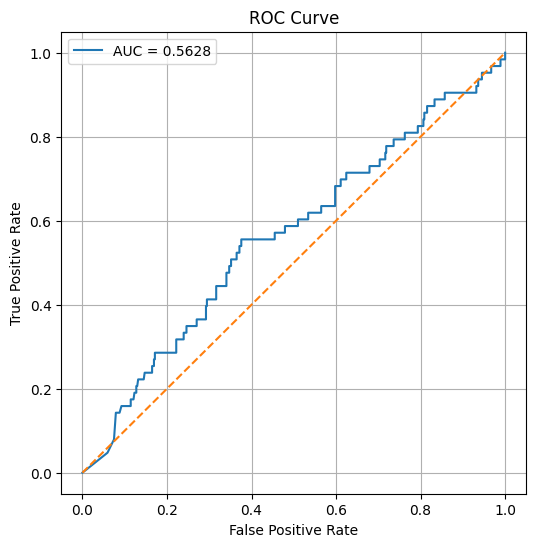

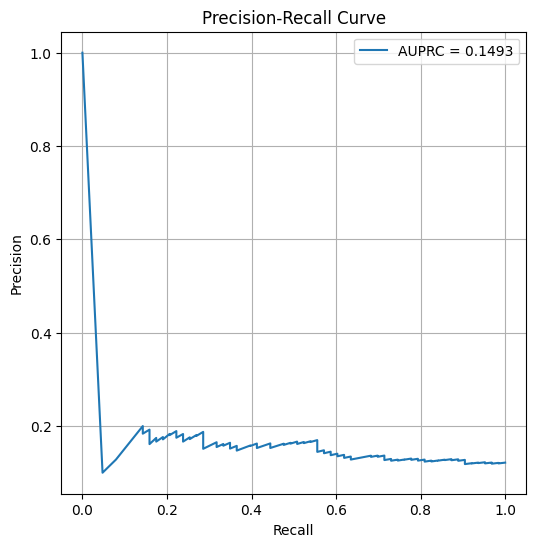

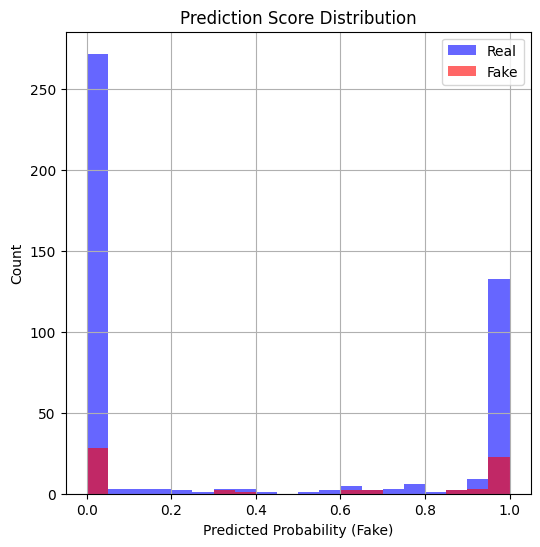

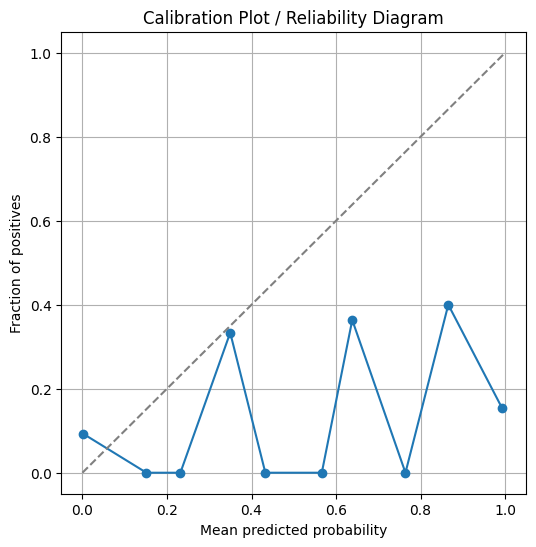

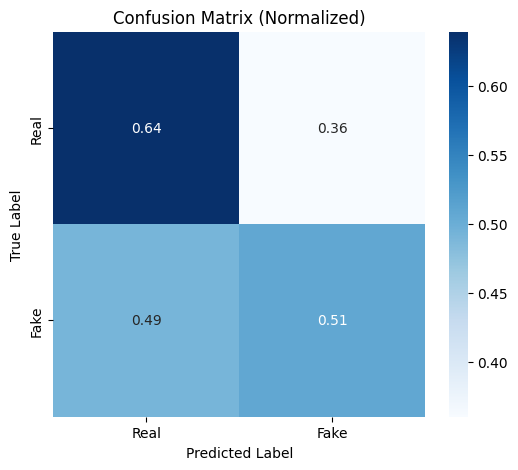

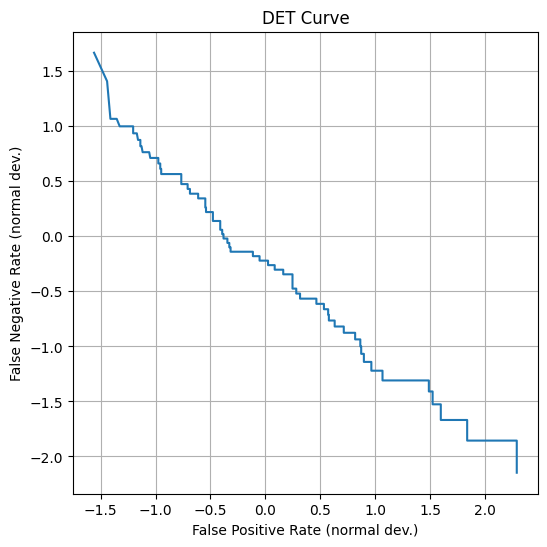

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FusionClassifier().to(device)
model.load_state_dict(torch.load("ml_model/fusion_model.pth"))

results = evaluate(model, test_loader, device)